# 作業四
資管碩二 R09725041 鄭宇伶

In [40]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

## 第一題

### a

In [2]:
records = [68, 71, 67, 69, 71, 70, 69, 67, 70, 70, 79, 79, 78, 78, 78, 79, 79, 82, 82, 81]

In [3]:

def ewma(records, lambda_coef, mu_0):
    return (
        [mu_0] + 
        [sum(
            [lambda_coef * ((1 - lambda_coef) ** (i - j)) * records[j] for j in range(i + 1)] + 
            [((1 - lambda_coef) ** (i + 1)) * mu_0]
         ) for i in range(len(records))
        ]
            
    )

def get_bounds(lambda_coef,  mu_0, std, L, n=1):
    unit_distance = [np.sqrt((lambda_coef / (2 - lambda_coef)) * (1 - (1 - lambda_coef)**(2 * t))) for t in range(len(records) + 1)]
    unit_distance = np.array(unit_distance)
    gap = L * (std / np.sqrt(n)) * unit_distance
    lcl = mu_0 - gap
    ucl = mu_0 + gap
    return lcl, ucl
    
def x_control(records, lambda_coef, mu_0, std, L, n=1):
    ma = ewma(records, lambda_coef, mu_0)
    lcl, ucl = get_bounds(lambda_coef, mu_0, std, L, n=1)
    
    plt.plot([70] + records, linestyle='solid', marker='o', label='Raw data')
    plt.plot(ma, linestyle='dotted', marker='o', label='EWMA')
    plt.plot(lcl, label='LCL', color='darkred', alpha=0.6)
    plt.plot(ucl, label='UCL', color='darkred', alpha=0.6) 
    plt.xlabel('Sample No.')
    plt.ylabel('Heart rate')
    plt.legend()
    

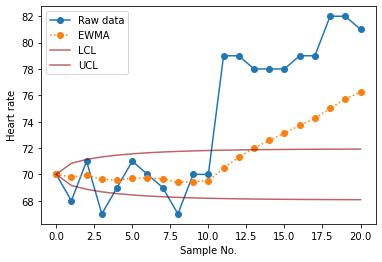

In [15]:
x_control(records, 0.1, 70, 3, 2.81)

可以看到在 EWMA 約 sample number 為 13 的時候超出上管制界線，所以並不是 in control。

### b

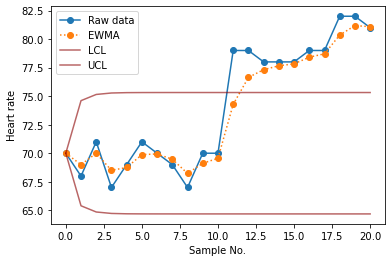

In [16]:
x_control(records, 0.5, 70, 3, 3.07)

可以明顯地看到 EWMA 更加貼近真實數據，也對於資料的變動更敏感，所以更早超出管制界線，在 sample number 為 12 時超出上管制界線。

### c

In [565]:
class ARLManager:
    def __init__(self, mu, std):
        self.mu = mu
        self.std = std
    def get_arl(self, lb, ub,):
        l_p = st.norm.cdf((lb - mu) / std)  
        u_p = 1 - st.norm.cdf((ub - mu) / std)
        p = l_p + u_p
        return p, 1 / p
    
def get_converge_bounds(lambda_coef,  mu_0, std, L, n=1):
    unit_distance = np.sqrt((lambda_coef / (2 - lambda_coef)) * (1 - 0)) 
    gap = L * (std / np.sqrt(n)) * unit_distance
    lcl = mu_0 - gap
    ucl = mu_0 + gap
    return lcl, ucl

In [566]:
mu = 76
std = 3
arl_manager = ARLManager(mu=76, std=3)
lcl, ucl = get_converge_bounds(0.1, 70, std, 2.81)
p, arl = arl_manager.get_arl(lcl, ucl)

In [567]:
print('假設實際平均數已經偏移至 76，依據每個時間點的 LCL、UCL 計算的 ARL')
print(arl)

假設實際平均數已經偏移至 76，依據每個時間點的 LCL、UCL 計算的 ARL
1.091185660928128


In [568]:
mu = 76
std = 3
arl_manager = ARLManager(mu=76, std=3)
lcl, ucl = get_converge_bounds(0.5, 70, std, 3.07)
p, arl = arl_manager.get_arl(lcl, ucl)

print('假設實際平均數已經偏移至 76，依據每個時間點的 LCL、UCL 計算的 ARL')
print(arl)

假設實際平均數已經偏移至 76，依據每個時間點的 LCL、UCL 計算的 ARL
1.694694610935147


### d



依據 a 小題設定，超出管制界線的機率是 0.92。

In [569]:
mu = 76
std = 3
arl_manager = ARLManager(mu=76, std=3)
lcl, ucl = get_converge_bounds(0.1, 70, std, 2.81)
p, arl = arl_manager.get_arl(lcl, ucl)
print(p)

0.9164343299282649


依據 b 小題的設定，超出管制界線的機率是 0.59。

In [570]:
mu = 76
std = 3
arl_manager = ARLManager(mu=76, std=3)
lcl, ucl = get_converge_bounds(0.5, 70, std, 3.07)
p, arl = arl_manager.get_arl(lcl, ucl)
print(p)

0.5900768159333388


### e
下一個沒有超出管制界線而下下一個有超出範圍的機率在 a、b 小題設定，分別為 (1- 0.92) * 0.92 = 0.072、(1-0.59) * 0.59 = 0.24。

## 第二題

### a

In [5]:
col_name = ["UnitNumber","Cycle","OpSet1","OpSet2","OpSet3","SensorMeasure1","SensorMeasure2","SensorMeasure3","SensorMeasure4","SensorMeasure5","SensorMeasure6","SensorMeasure7","SensorMeasure8","SensorMeasure9","SensorMeasure10","SensorMeasure11","SensorMeasure12","SensorMeasure13","SensorMeasure14","SensorMeasure15","SensorMeasure16","SensorMeasure17","SensorMeasure18","SensorMeasure19","SensorMeasure20","SensorMeasure21"]
col_dict = {}
for i in range(len(col_name)):
    col_dict[i] = col_name[i]

In [6]:
train_df = pd.read_csv('train.txt', header=None, sep=' ', index_col=None)

In [7]:
train_df = train_df.iloc[:, :26]

In [8]:
train_df = train_df.rename(columns=col_dict)

In [9]:
engines = train_df.UnitNumber.unique()

In [10]:
max_lifespan = pd.DataFrame(train_df.groupby(by='UnitNumber', sort=False)['Cycle'].max())

In [11]:
max_lifespan = max_lifespan.rename(columns={'Cycle': 'MaxCycle'})
max_lifespan = max_lifespan.reset_index()

In [12]:
train_df = pd.merge(train_df, max_lifespan, how='left', on='UnitNumber')

In [13]:
train_df['RUL'] = train_df['MaxCycle'] - train_df['Cycle']

In [14]:
train_df = train_df.drop(columns=['MaxCycle'])

In [15]:
train_df

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,2388.13,8120.83,8.6216,0.03,368,2319,100.00,28.58,17.1735,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,2388.15,8132.87,8.3907,0.03,391,2388,100.00,38.99,23.3619,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,2387.95,8063.84,9.3557,0.02,334,2223,100.00,14.83,8.8555,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,2388.07,8052.30,9.2231,0.02,364,2324,100.00,24.42,14.7832,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,2387.89,8083.67,9.2986,0.02,330,2212,100.00,10.99,6.4025,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45913,218,129,42.0066,0.8400,40.0,445.00,551.02,1365.27,1147.43,3.91,...,2387.39,8062.87,9.4672,0.02,333,2212,100.00,10.57,6.2985,4
45914,218,130,42.0029,0.8415,40.0,445.00,550.07,1365.55,1142.21,3.91,...,2387.28,8062.05,9.4619,0.02,332,2212,100.00,10.40,6.2741,3
45915,218,131,41.9999,0.8400,40.0,445.00,549.92,1359.21,1150.15,3.91,...,2387.33,8062.73,9.4827,0.02,334,2212,100.00,10.37,6.1978,2
45916,218,132,35.0007,0.8419,60.0,449.44,556.55,1380.05,1145.49,5.48,...,2387.56,8043.21,9.4212,0.02,337,2223,100.00,14.70,8.6761,1


### b

In [16]:
sensor_col = [col for col in col_name if col.startswith('SensorMeasure')]

In [17]:
def coef_var(sample):
    return np.std(sample, ddof=1) / np.mean(sample)

In [18]:
sensor_coef_var = train_df[sensor_col + ['UnitNumber']].groupby(by='UnitNumber').agg(coef_var)

In [19]:
sensor_coef_var

,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
UnitNumber,,,,,,,,,,,,,,,,,,,,,
1,0.053822,0.063875,0.075666,0.099492,0.447342,0.469649,0.528157,0.071501,0.040032,0.117559,...,0.529142,0.062518,0.011446,0.085792,0.200186,0.081075,0.071545,0.062519,0.481586,0.481438
2,0.057453,0.065570,0.075212,0.099887,0.458226,0.475623,0.521583,0.063604,0.039512,0.116537,...,0.522465,0.052569,0.009934,0.078438,0.201444,0.080515,0.063643,0.052580,0.480392,0.480361
3,0.056078,0.065745,0.076958,0.100848,0.454217,0.474847,0.528244,0.069198,0.040384,0.117517,...,0.528835,0.058790,0.010703,0.083272,0.204299,0.082140,0.069186,0.058772,0.483883,0.483639
4,0.054476,0.066435,0.080062,0.105318,0.417016,0.440645,0.496464,0.073207,0.042421,0.125320,...,0.497376,0.061696,0.011785,0.091332,0.204669,0.085396,0.073265,0.061705,0.453555,0.453786
5,0.054892,0.063616,0.074071,0.098123,0.440155,0.458388,0.506401,0.065059,0.039063,0.116850,...,0.507134,0.054864,0.010409,0.081062,0.202314,0.078863,0.065122,0.054885,0.465193,0.465405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.055331,0.063657,0.073701,0.097507,0.455736,0.473455,0.521455,0.064539,0.038702,0.114498,...,0.522106,0.054692,0.010178,0.079067,0.201741,0.078762,0.064579,0.054701,0.478690,0.479303
215,0.058060,0.066835,0.077339,0.103782,0.464982,0.484379,0.534796,0.066742,0.040709,0.119576,...,0.535296,0.055844,0.010345,0.081594,0.202681,0.083400,0.066758,0.055843,0.490034,0.490360
216,0.055826,0.062542,0.070376,0.094562,0.449434,0.463552,0.503447,0.057789,0.037345,0.112992,...,0.503923,0.047096,0.009148,0.072654,0.203624,0.075704,0.057860,0.047118,0.465811,0.465717


In [20]:
pd.concat(
    [
        pd.DataFrame(sensor_coef_var.idxmax(axis=1), columns=['Max col']), 
        pd.DataFrame(sensor_coef_var.max(axis=1), columns=['Max value']), 
        pd.DataFrame(sensor_coef_var.idxmin(axis=1), columns=['Min col']), 
        pd.DataFrame(sensor_coef_var.min(axis=1), columns=['Min value'])
    ],
    # ignore_index=False,
    join='inner',
    axis=1
)

,Max col,Max value,Min col,Min value
UnitNumber,,,,
1,SensorMeasure12,0.529142,SensorMeasure14,0.011446
2,SensorMeasure12,0.522465,SensorMeasure14,0.009934
3,SensorMeasure12,0.528835,SensorMeasure14,0.010703
4,SensorMeasure12,0.497376,SensorMeasure14,0.011785
5,SensorMeasure12,0.507134,SensorMeasure14,0.010409
...,...,...,...,...
214,SensorMeasure12,0.522106,SensorMeasure14,0.010178
215,SensorMeasure12,0.535296,SensorMeasure14,0.010345
216,SensorMeasure12,0.503923,SensorMeasure14,0.009148


In [21]:
sensor_coef_var = train_df[train_df['UnitNumber'] == 1][sensor_col].agg(coef_var)
sensor_coef_var.sort_values(ascending=False)

SensorMeasure12    0.529142
SensorMeasure7     0.528157
SensorMeasure20    0.481586
SensorMeasure21    0.481438
SensorMeasure6     0.469649
SensorMeasure5     0.447342
SensorMeasure16    0.200186
SensorMeasure10    0.117559
SensorMeasure4     0.099492
SensorMeasure15    0.085792
SensorMeasure17    0.081075
SensorMeasure11    0.080166
SensorMeasure3     0.075666
SensorMeasure18    0.071545
SensorMeasure8     0.071501
SensorMeasure2     0.063875
SensorMeasure19    0.062519
SensorMeasure13    0.062518
SensorMeasure1     0.053822
SensorMeasure9     0.040032
SensorMeasure14    0.011446
dtype: float64

可以發現 sensor 12、7 的 coefficient of variation 比較大，可能代表具有一定程度的變異，有可能與機台老化有關；而 sensor 9、14 的 coefficient of variation 較小，則可能較難以發現資訊。

### c

設定 time window 為 5。 

In [43]:
window_size = 5

In [44]:
m_avg = train_df[sensor_col + ['UnitNumber']].iloc[::-1].groupby(by='UnitNumber').rolling(window_size, min_periods=1).mean()

In [84]:
m_avg = m_avg.rename_axis(['UnitNumber', 'Cycle']).sort_index()[sensor_col]

In [85]:
m_avg

SensorMeasure1  SensorMeasure2  SensorMeasure3  \
UnitNumber Cycle                                                   
1          0          478.670000      591.646000        1459.018   
           1          479.098000      592.294000        1455.220   
           2          464.364000      573.782000        1409.196   
           3          478.210000      591.114000        1453.472   
           4          483.706000      598.248000        1473.020   
...                          ...             ...             ...   
218        45913      449.396000      549.004000        1348.946   
           45914      450.495000      548.500000        1344.865   
           45915      452.326667      547.976667        1337.970   
           45916      455.990000      547.005000        1327.350   
           45917      462.540000      537.460000        1274.650   

                  SensorMeasure4  SensorMeasure5  SensorMeasure6  \
UnitNumber Cycle                                                   
1          0            1241.980          8.7760       12.892000   
           1            1231.770          8.5420       12.524000   
           2            1177.266          6.4000        9.344000   
           3            1234.286          8.2280       12.066000   
           4            1264.252          9.2820       13.658000   
...                          ...             ...             ...   
218        45913        1130.810          4.8520        6.836000   
           45914        1126.655          5.0875        7.115000   
           45915        1121.470          5.4800        7.583333   
           45916        1107.130          6.2650        8.515000   
           45917        1068.770          7.0500        9.030000   

                  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
UnitNumber Cycle                                                   
1          0          323.308000     2293.078000     8639.192000   
           1          311.234000     2294.092000     8627.440000   
           2          228.322000     2258.854000     8481.664000   
           3          300.032000     2291.902000     8622.952000   
           4          343.848000     2304.752000     8688.916000   
...                          ...             ...             ...   
218        45913      156.664000     2154.252000     8247.492000   
           45914      161.337500     2139.982500     8233.565000   
           45915      169.263333     2116.213333     8210.523333   
           45916      184.870000     2068.700000     8161.080000   
           45917      175.150000     1914.860000     7991.490000   

                  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
UnitNumber Cycle                   ...                                     
1          0             1.136000  ...         304.5000      2388.038000   
           1             1.100000  ...         293.1420      2388.022000   
           2             1.044000  ...         214.8120      2387.968000   
           3             1.100000  ...         282.5080      2387.984000   
           4             1.144000  ...         323.8840      2387.986000   
...                           ...  ...              ...              ...   
218        45913         1.004000  ...         147.3040      2315.462000   
           45914         1.000000  ...         151.5775      2297.480000   
           45915         0.993333  ...         158.6900      2267.546667   
           45916         0.980000  ...         173.1050      2207.655000   
           45917         0.940000  ...         164.1800      2027.750000   

                  SensorMeasure14  SensorMeasure15  SensorMeasure16  \
UnitNumber Cycle                                                      
1          0          8090.702000         8.977940            0.024   
           1          8077.170000         9.099140            0.022   
           2          8066.998000         9.296060            0.020   
           3       

In [86]:
m_avg[m_avg.index.get_level_values('UnitNumber') == 1]

SensorMeasure1  SensorMeasure2  SensorMeasure3  \
UnitNumber Cycle                                                   
1          0          478.670000      591.646000     1459.018000   
           1          479.098000      592.294000     1455.220000   
           2          464.364000      573.782000     1409.196000   
           3          478.210000      591.114000     1453.472000   
           4          483.706000      598.248000     1473.020000   
...                          ...             ...             ...   
           218        471.636000      584.304000     1446.228000   
           219        477.185000      591.282500     1462.410000   
           220        486.433333      602.826667     1491.403333   
           221        470.315000      582.300000     1440.475000   
           222        449.440000      556.600000     1385.960000   

                  SensorMeasure4  SensorMeasure5  SensorMeasure6  \
UnitNumber Cycle                                                   
1          0         1241.980000        8.776000       12.892000   
           1         1231.770000        8.542000       12.524000   
           2         1177.266000        6.400000        9.344000   
           3         1234.286000        8.228000       12.066000   
           4         1264.252000        9.282000       13.658000   
...                          ...             ...             ...   
           218       1229.132000        8.082000       11.856000   
           219       1248.980000        8.732500       12.820000   
           220       1282.156667        9.816667       14.426667   
           221       1210.325000        7.415000       10.835000   
           222       1150.470000        5.480000        8.010000   

                  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
UnitNumber Cycle                                                   
1          0          323.308000     2293.078000        8639.192   
           1          311.234000     2294.092000        8627.440   
           2          228.322000     2258.854000        8481.664   
           3          300.032000     2291.902000        8622.952   
           4          343.848000     2304.752000        8688.916   
...                          ...             ...             ...   
           218        293.312000     2276.304000        8578.250   
           219        318.135000     2289.605000        8630.725   
           220        359.526667     2311.803333        8722.820   
           221        263.720000     2273.595000        8549.550   
           222        194.410000     2223.010000        8355.680   

                  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
UnitNumber Cycle                   ...                                     
1          0               1.1360  ...       304.500000      2388.038000   
           1               1.1000  ...       293.142000      2388.022000   
           2               1.0440  ...       214.812000      2387.968000   
           3               1.1000  ...       282.508000      2387.984000   
           4               1.1440  ...       323.884000      2387.986000   
...                           ...  ...              ...              ...   
           218             1.0860  ...       276.308000      2388.218000   
           219             1.1025  ...       299.755000      2388.245000   
           220             1.1300  ...       338.763333      2388.276667   
           221             1.0450  ...       248.125000      2388.275000   
           222             1.0200  ...       182.610000      2388.180000   

                  SensorMeasure14  SensorMeasure15  SensorMeasure16  \
UnitNumber Cycle                                                      
1          0          8090.702000         8.977940         0.024000   
           1          8077.170000         9.099140         0.022000   
           2          8066.998000         9.296060         0.020000   
           3       

In [83]:
m_var = train_df[sensor_col + ['UnitNumber']].iloc[::-1].groupby(by='UnitNumber').rolling(window_size, min_periods=1).var()
m_var = m_var.rename_axis(['UnitNumber', 'Cycle']).sort_index()[sensor_col]
m_var = m_var.fillna(0)
m_var[m_var.index.get_level_values('UnitNumber') == 1]

SensorMeasure1  SensorMeasure2  SensorMeasure3  \
UnitNumber Cycle                                                   
1          0          963.139150     1507.018730     9360.059070   
           1          975.161670     1529.342330     9048.281250   
           2          602.980830      936.402970     4758.614330   
           3         1044.945150     1642.768630    10019.267270   
           4         1374.320430     2181.100270    13638.774950   
...                          ...             ...             ...   
           218       1018.135830     1605.561730     9207.611070   
           219       1152.238433     1816.085892    10531.100600   
           220       1215.167633     1924.522133    10752.970633   
           221        871.531250     1320.980000     5943.770450   
           222          0.000000        0.000000        0.000000   

                  SensorMeasure4  SensorMeasure5  SensorMeasure6  \
UnitNumber Cycle                                                   
1          0        14757.754250       18.016230       39.710120   
           1        13544.040500       17.269770       37.997080   
           2         4934.861180        7.662900       16.325380   
           3        13382.944380       20.166420       44.225880   
           4        18988.534170       28.677470       63.202520   
...                          ...             ...             ...   
           218      14802.782170       16.166120       35.731030   
           219      17110.755533       18.733825       41.446067   
           220      19061.986033       21.048233       46.680833   
           221       7165.242050        7.488450       15.961250   
           222          0.000000        0.000000        0.000000   

                  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
UnitNumber Cycle                                                   
1          0        27263.200970     5540.227170    95454.393970   
           1        25831.707530     5610.750870    92295.926450   
           2         9951.572170     3545.627880    46096.596530   
           3        29676.841870     6032.655120    97250.623370   
           4        43086.728670     7884.597120   135263.367830   
...                          ...             ...             ...   
           218      24391.030970     5832.117230   103039.123000   
           219      28413.499100     6596.712300   119027.993167   
           220      32340.628233     6938.472433   127653.055600   
           221       9607.752200     5117.684450    75171.153800   
           222          0.000000        0.000000        0.000000   

                  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
UnitNumber Cycle                   ...                                     
1          0             0.018080  ...     24225.773850         0.012920   
           1             0.013400  ...     22949.872920         0.010520   
           2             0.001080  ...      8848.906320         0.007820   
           3             0.013400  ...     26422.787920         0.008380   
           4             0.020880  ...     38327.076880         0.008830   
...                           ...  ...              ...              ...   
           218           0.014780  ...     21782.828070         0.011170   
           219           0.017892  ...     25378.692033         0.010033   
           220           0.022300  ...     28938.137633         0.009033   
           221           0.001250  ...      8584.430450         0.018050   
           222           0.000000  ...         0.000000         0.000000   

                  SensorMeasure14  SensorMeasure15  SensorMeasure16  \
UnitNumber Cycle                                                      
1          0          1232.891570         0.194364         0.000030   
           1          1129.236450         0.159841         0.000020   
           2           230.133370         0.004963         0.000000   
           3       

In [82]:
m_max = train_df[sensor_col + ['UnitNumber']].iloc[::-1].groupby(by='UnitNumber').rolling(window_size, min_periods=1).max()
m_max = m_max.rename_axis(['UnitNumber', 'Cycle']).sort_index()[sensor_col]
m_max[m_max.index.get_level_values('UnitNumber') == 1]

SensorMeasure1  SensorMeasure2  SensorMeasure3  \
UnitNumber Cycle                                                   
1          0              518.67          642.13         1584.55   
           1              518.67          642.13         1584.55   
           2              491.19          607.37         1488.44   
           3              518.67          642.08         1589.55   
           4              518.67          642.70         1589.55   
...                          ...             ...             ...   
           218            518.67          643.88         1593.26   
           219            518.67          643.88         1593.26   
           220            518.67          643.88         1593.26   
           221            491.19          608.00         1494.99   
           222            449.44          556.60         1385.96   

                  SensorMeasure4  SensorMeasure5  SensorMeasure6  \
UnitNumber Cycle                                                   
1          0             1403.96           14.62           21.61   
           1             1403.96           14.62           21.61   
           2             1258.90            9.35           13.65   
           3             1407.59           14.62           21.61   
           4             1407.59           14.62           21.61   
...                          ...             ...             ...   
           218           1425.82           14.62           21.61   
           219           1425.82           14.62           21.61   
           220           1425.82           14.62           21.61   
           221           1270.18            9.35           13.66   
           222           1150.47            5.48            8.01   

                  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
UnitNumber Cycle                                                   
1          0              553.67         2388.01         9045.76   
           1              553.67         2388.01         9045.76   
           2              334.82         2323.94         8721.53   
           3              553.48         2388.10         9050.35   
           4              553.90         2388.10         9051.35   
...                          ...             ...             ...   
           218            551.14         2388.22         9069.36   
           219            551.14         2388.22         9069.36   
           220            551.14         2388.22         9069.36   
           221            333.03         2324.18         8743.42   
           222            194.41         2223.01         8355.68   

                  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
UnitNumber Cycle                   ...                                     
1          0                 1.30  ...           521.81          2388.15   
           1                 1.30  ...           521.81          2388.15   
           2                 1.08  ...           315.36          2388.07   
           3                 1.30  ...           521.74          2388.07   
           4                 1.30  ...           521.74          2388.08   
...                           ...  ...              ...              ...   
           218               1.30  ...           520.04          2388.37   
           219               1.30  ...           520.04          2388.37   
           220               1.30  ...           520.04          2388.37   
           221               1.07  ...           313.64          2388.37   
           222               1.02  ...           182.61          2388.18   

                  SensorMeasure14  SensorMeasure15  SensorMeasure16  \
UnitNumber Cycle                                                      
1          0              8132.87           9.3557             0.03   
           1              8132.87           9.3557             0.03   
           2              8083.67           9.3753             0.02   
           3       

### d

In [61]:
m_avg_rul = train_df[['UnitNumber', 'RUL']].iloc[::-1].groupby(by='UnitNumber').rolling(window_size, min_periods=1).mean()[['RUL']]
m_avg_rul = m_avg_rul.reset_index().rename(columns={'level_1': 'Cycle'}).sort_values(by=['Cycle', 'UnitNumber']).reset_index(drop=True).rename(columns={'RUL': 'AvgRUL'})

m_var_rul = train_df[['UnitNumber', 'RUL']].iloc[::-1].groupby(by='UnitNumber').rolling(window_size, min_periods=1).var()[['RUL']]
m_var_rul = m_var_rul.reset_index().rename(columns={'level_1': 'Cycle'}).sort_values(by=['Cycle', 'UnitNumber']).reset_index(drop=True).rename(columns={'RUL': 'VarRUL'})
m_var_rul = m_var_rul.fillna(0)

m_max_rul = train_df[['UnitNumber', 'RUL']].iloc[::-1].groupby(by='UnitNumber').rolling(window_size, min_periods=1).max()[['RUL']]
m_max_rul = m_max_rul.reset_index().rename(columns={'level_1': 'Cycle'}).sort_values(by=['Cycle', 'UnitNumber']).reset_index(drop=True).rename(columns={'RUL': 'MaxRUL'})

# avg_df = pd.merge(m_avg, m_avg_rul, on=['UnitNumber', 'Cycle'])

In [62]:
m_rul = pd.merge(m_avg_rul, m_var_rul, on=['UnitNumber', 'Cycle'])
m_rul = pd.merge(m_rul, m_max_rul, on=['UnitNumber', 'Cycle'])

In [108]:
avg_df = pd.merge(m_avg, m_rul, on=['UnitNumber', 'Cycle'])  

In [109]:
group_corr = avg_df.groupby('UnitNumber').corr()

In [110]:
group_corr = group_corr.rename_axis(['UnitNumber', 'RUL'])

In [111]:
group_corr = group_corr.iloc[group_corr.index.get_level_values('RUL').isin(['AvgRUL', 'VarRUL', 'MaxRUL']), 1:-3]

In [112]:
group_corr

SensorMeasure2  SensorMeasure3  SensorMeasure4  \
UnitNumber RUL                                                      
1          AvgRUL        0.091588        0.011609        0.026563   
           VarRUL       -0.033055       -0.080747       -0.046257   
           MaxRUL        0.091475        0.011405        0.026448   
2          AvgRUL       -0.107957       -0.185774       -0.194897   
           VarRUL        0.255039        0.279865        0.226228   
...                           ...             ...             ...   
217        VarRUL        0.195564        0.186734        0.185118   
           MaxRUL        0.110118        0.100397        0.074946   
218        AvgRUL        0.279605        0.217563        0.169478   
           VarRUL        0.314812        0.328084        0.296044   
           MaxRUL        0.281031        0.219193        0.170987   

                   SensorMeasure5  SensorMeasure6  SensorMeasure7  \
UnitNumber RUL                                                      
1          AvgRUL        0.169066        0.159325        0.153348   
           VarRUL        0.025161        0.011242       -0.001386   
           MaxRUL        0.169068        0.159293        0.153283   
2          AvgRUL        0.025858        0.006493       -0.006418   
           VarRUL        0.082773        0.123147        0.175856   
...                           ...             ...             ...   
217        VarRUL        0.142995        0.153624        0.166914   
           MaxRUL        0.028630        0.053489        0.090086   
218        AvgRUL        0.301246        0.300039        0.298021   
           VarRUL        0.172259        0.206802        0.247253   
           MaxRUL        0.301729        0.300745        0.298989   

                   SensorMeasure8  SensorMeasure9  SensorMeasure10  \
UnitNumber RUL                                                       
1          AvgRUL       -0.009223        0.061767         0.155315   
           VarRUL       -0.108490       -0.052302         0.036258   
           MaxRUL       -0.009501        0.061614         0.155345   
2          AvgRUL       -0.159545       -0.078127         0.034887   
           VarRUL        0.395201        0.325627         0.263948   
...                           ...             ...              ...   
217        VarRUL        0.176506        0.168711         0.202148   
           MaxRUL        0.207856        0.052013         0.147128   
218        AvgRUL        0.214969        0.280042         0.228125   
           VarRUL        0.421388        0.366822         0.309708   
           MaxRUL        0.217212        0.281803         0.229618   

                   SensorMeasure11  SensorMeasure12  SensorMeasure13  \
UnitNumber RUL                                                         
1          AvgRUL        -0.061081         0.152933        -0.078324   
           VarRUL        -0.108165        -0.001321        -0.137742   
           MaxRUL        -0.061323         0.152870        -0.078656   
2          AvgRUL        -0.271505        -0.006644        -0.182120   
           VarRUL         0.309153         0.176070         0.410416   
...                            ...              ...              ...   
217        VarRUL         0.177331         0.166779         0.129677   
           MaxRUL         0.130343         0.090458         0.228082   
218        AvgRUL         0.129213         0.296765         0.129795   
           VarRUL         0.352177         0.248631         0.439623   
           MaxRUL         0.131167         0.297743         0.132330   

                   SensorMeasure14  SensorMeasure15  SensorMeasure16  \
UnitNumber RUL                                                         
1          AvgRUL        -0.039598        -0.098382        -0.022148   
           VarRUL        -0.090961         0.049827        -0.032637   
           MaxRUL        -0.039818        -0.098199        -0.022189   
2          AvgR

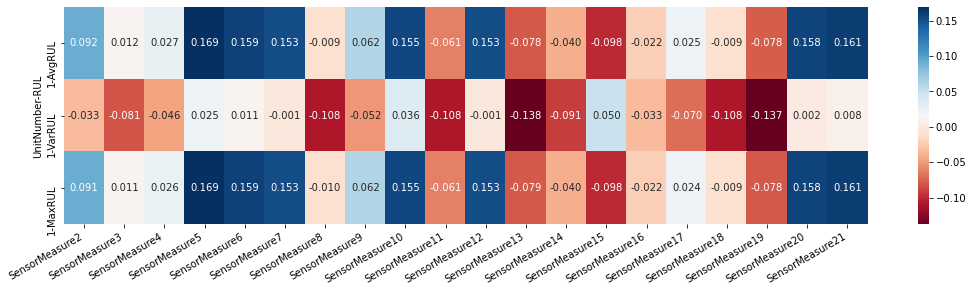

In [113]:
fig, ax = plt.subplots(figsize=(18, 4))
sns.heatmap(group_corr.iloc[group_corr.index.get_level_values('UnitNumber') == 1], annot=True,  fmt='.3f', cmap='RdBu')
plt.xticks(rotation=30, ha='right')
plt.show()

In [114]:
max_abs_id = group_corr.iloc[group_corr.index.get_level_values('UnitNumber') == 1].abs().to_numpy().argsort()[:, -10:]

In [115]:
for i in range(len(max_abs_id)):
    print(f'Top 10 highest absolute correlation by {group_corr.index.get_level_values("RUL")[i]} on engine {group_corr.index.get_level_values("UnitNumber")[i]}')
    print(group_corr.iloc[i, max_abs_id[i][::-1]])
    print()
        

Top 10 highest absolute correlation by AvgRUL on engine 1
SensorMeasure5     0.169066
SensorMeasure21    0.160975
SensorMeasure6     0.159325
SensorMeasure20    0.157744
SensorMeasure10    0.155315
SensorMeasure7     0.153348
SensorMeasure12    0.152933
SensorMeasure15   -0.098382
SensorMeasure2     0.091588
SensorMeasure13   -0.078324
Name: (1, AvgRUL), dtype: float64

Top 10 highest absolute correlation by VarRUL on engine 1
SensorMeasure13   -0.137742
SensorMeasure19   -0.137375
SensorMeasure8    -0.108490
SensorMeasure18   -0.108321
SensorMeasure11   -0.108165
SensorMeasure14   -0.090961
SensorMeasure3    -0.080747
SensorMeasure17   -0.069562
SensorMeasure9    -0.052302
SensorMeasure15    0.049827
Name: (1, VarRUL), dtype: float64

Top 10 highest absolute correlation by MaxRUL on engine 1
SensorMeasure5     0.169068
SensorMeasure21    0.160932
SensorMeasure6     0.159293
SensorMeasure20    0.157687
SensorMeasure10    0.155345
SensorMeasure7     0.153283
SensorMeasure12    0.152870


In [116]:
max_abs_id = group_corr.abs().to_numpy().argsort()[:, -10:]
top_sensor = []
for i in range(len(max_abs_id)):
    top_sensor.append(np.concatenate([[group_corr.index.get_level_values("UnitNumber")[i], group_corr.index.get_level_values("RUL")[i]], group_corr.iloc[i, max_abs_id[i][::-1]].index]))

In [117]:
top_sensor = pd.DataFrame(top_sensor, columns=['UnitNumber', 'RUL'] + [f'Top{i + 1}' for i in range(10)])
top_sensor = top_sensor.set_index(['UnitNumber', 'RUL'])
top_sensor_avg = top_sensor
top_sensor_avg

Top1             Top2             Top3  \
UnitNumber RUL                                                         
1          AvgRUL   SensorMeasure5  SensorMeasure21   SensorMeasure6   
           VarRUL  SensorMeasure13  SensorMeasure19   SensorMeasure8   
           MaxRUL   SensorMeasure5  SensorMeasure21   SensorMeasure6   
2          AvgRUL  SensorMeasure11   SensorMeasure4  SensorMeasure17   
           VarRUL  SensorMeasure14  SensorMeasure15  SensorMeasure13   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure10   SensorMeasure2  SensorMeasure15   
           MaxRUL  SensorMeasure15  SensorMeasure19  SensorMeasure13   
218        AvgRUL  SensorMeasure21  SensorMeasure20   SensorMeasure5   
           VarRUL  SensorMeasure14  SensorMeasure13  SensorMeasure19   
           MaxRUL  SensorMeasure21  SensorMeasure20   SensorMeasure5   

                              Top4             Top5             Top6  \
UnitNumber RUL                                                         
1          AvgRUL  SensorMeasure20  SensorMeasure10   SensorMeasure7   
           VarRUL  SensorMeasure18  SensorMeasure11  SensorMeasure14   
           MaxRUL  SensorMeasure20  SensorMeasure10   SensorMeasure7   
2          AvgRUL   SensorMeasure3  SensorMeasure19  SensorMeasure13   
           VarRUL  SensorMeasure19   SensorMeasure8  SensorMeasure18   
...                            ...              ...              ...   
217        VarRUL   SensorMeasure3   SensorMeasure4  SensorMeasure16   
           MaxRUL  SensorMeasure18   SensorMeasure8  SensorMeasure10   
218        AvgRUL   SensorMeasure6   SensorMeasure7  SensorMeasure12   
           VarRUL  SensorMeasure15   SensorMeasure8  SensorMeasure18   
           MaxRUL   SensorMeasure6   SensorMeasure7  SensorMeasure12   

                              Top7             Top8             Top9  \
UnitNumber RUL                                                         
1          AvgRUL  SensorMeasure12  SensorMeasure15   SensorMeasure2   
           VarRUL   SensorMeasure3  SensorMeasure17   SensorMeasure9   
           MaxRUL  SensorMeasure12  SensorMeasure15   SensorMeasure2   
2          AvgRUL  SensorMeasure18   SensorMeasure8   SensorMeasure2   
           VarRUL   SensorMeasure9  SensorMeasure11   SensorMeasure3   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure17  SensorMeasure18  SensorMeasure11   
           MaxRUL  SensorMeasure14  SensorMeasure11  SensorMeasure16   
218        AvgRUL   SensorMeasure9   SensorMeasure2  SensorMeasure15   
           VarRUL   SensorMeasure9  SensorMeasure11  SensorMeasure17   
           MaxRUL   SensorMeasure9   SensorMeasure2  SensorMeasure15   

                             Top10  
UnitNumber RUL                      
1          AvgRUL  SensorMeasure13  
           VarRUL  SensorMeasure15  
           MaxRUL  SensorMeasure13  
2          AvgRUL   SensorMeasure9  
           VarRUL  SensorMeasure17  
...                            ...  
217        VarRUL   SensorMeasure8  
           MaxRUL   SensorMeasure2  
218        AvgRUL  SensorMeasure14  
           VarRUL   SensorMeasure3  
           MaxRUL  SensorMeasure14  

[654 rows x 10 columns]

#### 變異

In [118]:
var_df = pd.merge(m_var, m_rul, on=['UnitNumber', 'Cycle'])
group_corr = var_df.groupby('UnitNumber').corr()

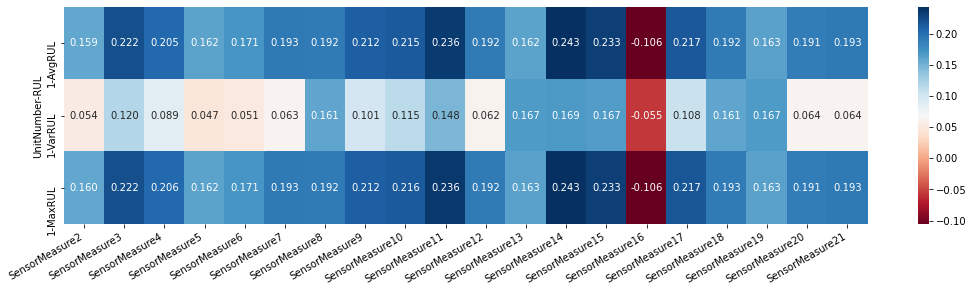

Top 10 highest absolute correlation by AvgRUL on engine 1
SensorMeasure14    0.242768
SensorMeasure11    0.236021
SensorMeasure15    0.232769
SensorMeasure3     0.221748
SensorMeasure17    0.217076
SensorMeasure10    0.215379
SensorMeasure9     0.212132
SensorMeasure4     0.205378
SensorMeasure7     0.192885
SensorMeasure21    0.192756
Name: (1, AvgRUL), dtype: float64

Top 10 highest absolute correlation by VarRUL on engine 1
SensorMeasure14    0.168631
SensorMeasure19    0.166712
SensorMeasure13    0.166706
SensorMeasure15    0.166596
SensorMeasure18    0.160632
SensorMeasure8     0.160600
SensorMeasure11    0.147729
SensorMeasure3     0.119870
SensorMeasure10    0.114948
SensorMeasure17    0.107856
Name: (1, VarRUL), dtype: float64

Top 10 highest absolute correlation by MaxRUL on engine 1
SensorMeasure14    0.243090
SensorMeasure11    0.236301
SensorMeasure15    0.233095
SensorMeasure3     0.221968
SensorMeasure17    0.217267
SensorMeasure10    0.215598
SensorMeasure9     0.212308


Top1             Top2             Top3  \
UnitNumber RUL                                                         
1          AvgRUL  SensorMeasure14  SensorMeasure11  SensorMeasure15   
           VarRUL  SensorMeasure14  SensorMeasure19  SensorMeasure13   
           MaxRUL  SensorMeasure14  SensorMeasure11  SensorMeasure15   
2          AvgRUL  SensorMeasure14  SensorMeasure19  SensorMeasure13   
           VarRUL  SensorMeasure16  SensorMeasure13  SensorMeasure19   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure16   SensorMeasure2  SensorMeasure20   
           MaxRUL  SensorMeasure18  SensorMeasure14   SensorMeasure8   
218        AvgRUL  SensorMeasure14  SensorMeasure19  SensorMeasure13   
           VarRUL   SensorMeasure2  SensorMeasure16  SensorMeasure20   
           MaxRUL  SensorMeasure14  SensorMeasure19  SensorMeasure13   

                              Top4             Top5             Top6  \
UnitNumber RUL                                                         
1          AvgRUL   SensorMeasure3  SensorMeasure17  SensorMeasure10   
           VarRUL  SensorMeasure15  SensorMeasure18   SensorMeasure8   
           MaxRUL   SensorMeasure3  SensorMeasure17  SensorMeasure10   
2          AvgRUL  SensorMeasure15  SensorMeasure18   SensorMeasure8   
           VarRUL  SensorMeasure15  SensorMeasure20   SensorMeasure5   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure21  SensorMeasure10   SensorMeasure7   
           MaxRUL  SensorMeasure15  SensorMeasure19  SensorMeasure13   
218        AvgRUL  SensorMeasure15   SensorMeasure8  SensorMeasure18   
           VarRUL  SensorMeasure21  SensorMeasure12   SensorMeasure7   
           MaxRUL  SensorMeasure15   SensorMeasure8  SensorMeasure18   

                              Top7             Top8             Top9  \
UnitNumber RUL                                                         
1          AvgRUL   SensorMeasure9   SensorMeasure4   SensorMeasure7   
           VarRUL  SensorMeasure11   SensorMeasure3  SensorMeasure10   
           MaxRUL   SensorMeasure9   SensorMeasure4   SensorMeasure7   
2          AvgRUL  SensorMeasure11   SensorMeasure5   SensorMeasure6   
           VarRUL   SensorMeasure6  SensorMeasure21   SensorMeasure8   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure12   SensorMeasure6   SensorMeasure4   
           MaxRUL  SensorMeasure11  SensorMeasure16   SensorMeasure5   
218        AvgRUL  SensorMeasure11  SensorMeasure20  SensorMeasure21   
           VarRUL   SensorMeasure6   SensorMeasure5   SensorMeasure4   
           MaxRUL  SensorMeasure11  SensorMeasure20  SensorMeasure21   

                             Top10  
UnitNumber RUL                      
1          AvgRUL  SensorMeasure21  
           VarRUL  SensorMeasure17  
           MaxRUL  SensorMeasure21  
2          AvgRUL  SensorMeasure10  
           VarRUL  SensorMeasure18  
...                            ...  
217        VarRUL   SensorMeasure5  
           MaxRUL   SensorMeasure6  
218        AvgRUL  SensorMeasure12  
           VarRUL  SensorMeasure10  
           MaxRUL  SensorMeasure12  

[654 rows x 10 columns]

In [119]:
group_corr = group_corr.rename_axis(['UnitNumber', 'RUL'])
group_corr = group_corr.iloc[group_corr.index.get_level_values('RUL').isin(['AvgRUL', 'VarRUL', 'MaxRUL']), 1:-3]

fig, ax = plt.subplots(figsize=(18, 4))
sns.heatmap(group_corr.iloc[group_corr.index.get_level_values('UnitNumber') == 1], annot=True,  fmt='.3f', cmap='RdBu')
plt.xticks(rotation=30, ha='right')
plt.show()

max_abs_id = group_corr.iloc[group_corr.index.get_level_values('UnitNumber') == 1].abs().to_numpy().argsort()[:, -10:]
for i in range(len(max_abs_id)):
    print(f'Top 10 highest absolute correlation by {group_corr.index.get_level_values("RUL")[i]} on engine {group_corr.index.get_level_values("UnitNumber")[i]}')
    print(group_corr.iloc[i, max_abs_id[i][::-1]])
    print()
        
max_abs_id = group_corr.abs().to_numpy().argsort()[:, -10:]
top_sensor = []
for i in range(len(max_abs_id)):
    top_sensor.append(np.concatenate([[group_corr.index.get_level_values("UnitNumber")[i], group_corr.index.get_level_values("RUL")[i]], group_corr.iloc[i, max_abs_id[i][::-1]].index]))

top_sensor = pd.DataFrame(top_sensor, columns=['UnitNumber', 'RUL'] + [f'Top{i + 1}' for i in range(10)])
top_sensor = top_sensor.set_index(['UnitNumber', 'RUL'])
top_sensor_var = top_sensor
top_sensor_var

#### 最大值

In [120]:
max_df = pd.merge(m_max, m_rul, on=['UnitNumber', 'Cycle'])
group_corr = max_df.groupby('UnitNumber').corr()

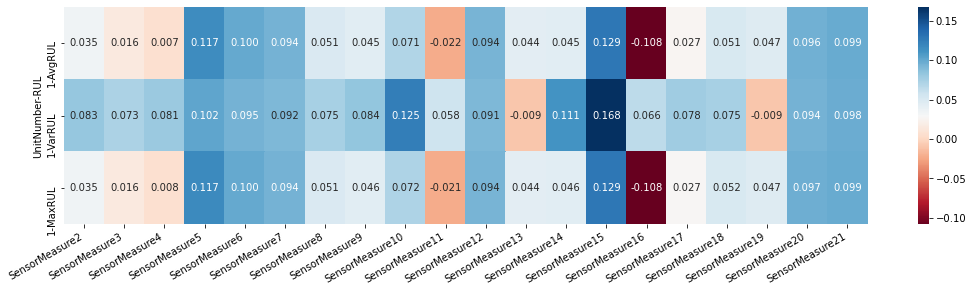

Top 10 highest absolute correlation by AvgRUL on engine 1
SensorMeasure15    0.129103
SensorMeasure5     0.116738
SensorMeasure16   -0.108476
SensorMeasure6     0.099992
SensorMeasure21    0.099142
SensorMeasure20    0.096326
SensorMeasure7     0.094255
SensorMeasure12    0.093625
SensorMeasure10    0.071404
SensorMeasure18    0.051467
Name: (1, AvgRUL), dtype: float64

Top 10 highest absolute correlation by VarRUL on engine 1
SensorMeasure15    0.167527
SensorMeasure10    0.124730
SensorMeasure14    0.111472
SensorMeasure5     0.102086
SensorMeasure21    0.097668
SensorMeasure6     0.094679
SensorMeasure20    0.094346
SensorMeasure7     0.091522
SensorMeasure12    0.091158
SensorMeasure9     0.084283
Name: (1, VarRUL), dtype: float64

Top 10 highest absolute correlation by MaxRUL on engine 1
SensorMeasure15    0.129487
SensorMeasure5     0.116993
SensorMeasure16   -0.108200
SensorMeasure6     0.100235
SensorMeasure21    0.099392
SensorMeasure20    0.096568
SensorMeasure7     0.094490


Top1             Top2             Top3  \
UnitNumber RUL                                                         
1          AvgRUL  SensorMeasure15   SensorMeasure5  SensorMeasure16   
           VarRUL  SensorMeasure15  SensorMeasure10  SensorMeasure14   
           MaxRUL  SensorMeasure15   SensorMeasure5  SensorMeasure16   
2          AvgRUL  SensorMeasure14  SensorMeasure15  SensorMeasure19   
           VarRUL  SensorMeasure13  SensorMeasure19  SensorMeasure14   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure19  SensorMeasure13  SensorMeasure18   
           MaxRUL  SensorMeasure19  SensorMeasure13  SensorMeasure14   
218        AvgRUL  SensorMeasure14  SensorMeasure18   SensorMeasure8   
           VarRUL  SensorMeasure13  SensorMeasure19  SensorMeasure14   
           MaxRUL  SensorMeasure14  SensorMeasure18   SensorMeasure8   

                              Top4             Top5             Top6  \
UnitNumber RUL                                                         
1          AvgRUL   SensorMeasure6  SensorMeasure21  SensorMeasure20   
           VarRUL   SensorMeasure5  SensorMeasure21   SensorMeasure6   
           MaxRUL   SensorMeasure6  SensorMeasure21  SensorMeasure20   
2          AvgRUL  SensorMeasure13  SensorMeasure11   SensorMeasure4   
           VarRUL  SensorMeasure18   SensorMeasure8   SensorMeasure9   
...                            ...              ...              ...   
217        VarRUL   SensorMeasure8   SensorMeasure2   SensorMeasure3   
           MaxRUL  SensorMeasure15  SensorMeasure16   SensorMeasure5   
218        AvgRUL   SensorMeasure9   SensorMeasure2  SensorMeasure21   
           VarRUL  SensorMeasure18   SensorMeasure8  SensorMeasure11   
           MaxRUL   SensorMeasure9   SensorMeasure2  SensorMeasure21   

                              Top7             Top8             Top9  \
UnitNumber RUL                                                         
1          AvgRUL   SensorMeasure7  SensorMeasure12  SensorMeasure10   
           VarRUL  SensorMeasure20   SensorMeasure7  SensorMeasure12   
           MaxRUL   SensorMeasure7  SensorMeasure12  SensorMeasure10   
2          AvgRUL  SensorMeasure10  SensorMeasure18   SensorMeasure8   
           VarRUL  SensorMeasure11   SensorMeasure3  SensorMeasure17   
...                            ...              ...              ...   
217        VarRUL  SensorMeasure17   SensorMeasure4  SensorMeasure11   
           MaxRUL   SensorMeasure6  SensorMeasure21  SensorMeasure20   
218        AvgRUL  SensorMeasure20   SensorMeasure7  SensorMeasure12   
           VarRUL   SensorMeasure9  SensorMeasure17   SensorMeasure3   
           MaxRUL  SensorMeasure20   SensorMeasure7  SensorMeasure12   

                             Top10  
UnitNumber RUL                      
1          AvgRUL  SensorMeasure18  
           VarRUL   SensorMeasure9  
           MaxRUL  SensorMeasure18  
2          AvgRUL   SensorMeasure3  
           VarRUL   SensorMeasure2  
...                            ...  
217        VarRUL  SensorMeasure21  
           MaxRUL   SensorMeasure7  
218        AvgRUL  SensorMeasure19  
           VarRUL   SensorMeasure2  
           MaxRUL  SensorMeasure19  

[654 rows x 10 columns]

In [121]:
group_corr = group_corr.rename_axis(['UnitNumber', 'RUL'])
group_corr = group_corr.iloc[group_corr.index.get_level_values('RUL').isin(['AvgRUL', 'VarRUL', 'MaxRUL']), 1:-3]

fig, ax = plt.subplots(figsize=(18, 4))
sns.heatmap(group_corr.iloc[group_corr.index.get_level_values('UnitNumber') == 1], annot=True,  fmt='.3f', cmap='RdBu')
plt.xticks(rotation=30, ha='right')
plt.show()

max_abs_id = group_corr.iloc[group_corr.index.get_level_values('UnitNumber') == 1].abs().to_numpy().argsort()[:, -10:]
for i in range(len(max_abs_id)):
    print(f'Top 10 highest absolute correlation by {group_corr.index.get_level_values("RUL")[i]} on engine {group_corr.index.get_level_values("UnitNumber")[i]}')
    print(group_corr.iloc[i, max_abs_id[i][::-1]])
    print()
        
max_abs_id = group_corr.abs().to_numpy().argsort()[:, -10:]
top_sensor = []
for i in range(len(max_abs_id)):
    top_sensor.append(np.concatenate([[group_corr.index.get_level_values("UnitNumber")[i], group_corr.index.get_level_values("RUL")[i]], group_corr.iloc[i, max_abs_id[i][::-1]].index]))

top_sensor = pd.DataFrame(top_sensor, columns=['UnitNumber', 'RUL'] + [f'Top{i + 1}' for i in range(10)])
top_sensor = top_sensor.set_index(['UnitNumber', 'RUL'])
top_sensor_max = top_sensor
top_sensor_max

### e

In [122]:
def smape(true_y, pred_y):
    diff = 2 * np.abs(pred_y - true_y) / (np.abs(true_y) + np.abs(pred_y))
    return 100 * np.mean(diff)

smape_score = make_scorer(smape, greater_is_better=False)

In [144]:
def report(gs, result, scoring, X, y, search_time, feature_names, parameter, name):
    
    def plot_grids(parameter, result, name):
        grids = pd.DataFrame(columns=parameter['n_estimators'])
        grids['alpha'] = parameter['ccp_alpha']
        grids = grids.set_index('alpha')
        for i, key in enumerate(result.cv_results_['params']):
            grids.loc[key['ccp_alpha'], key['n_estimators']] = -1 * (result.cv_results_['mean_test_mse'][i])
        fig, ax = plt.subplots(figsize=(10,16)) 
        sns.heatmap(-1 * result.cv_results_['mean_test_mse'].reshape(len(parameter['ccp_alpha']), len(parameter['n_estimators'])), 
                    cmap="RdBu_r", annot=True, fmt="0.3f", 
                    yticklabels=parameter['ccp_alpha'],
                    xticklabels=parameter['n_estimators'])
        plt.xlabel('n_estimators', fontsize=15)
        plt.ylabel('ccp_alpha', fontsize=15)
        plt.title(f'Grid search CV f1 score on moving {name} data', fontsize=16)
        plt.show()

    def show_cv(gs, result, scoring, X, y, search_time, name):
        print(f'Best hyperparameter: {result.best_params_}')
        best_id = result.best_index_
        print(f'Search time: {search_time} seconds')
        for metric in scoring:
            print(f'{metric} in validation: mean={-1 * result.cv_results_[f"mean_test_{metric}"][best_id]}, std={result.cv_results_[f"std_test_{metric}"][best_id]}')

       
        rf = RandomForestRegressor(ccp_alpha=result.best_params_['ccp_alpha'], n_estimators=result.best_params_['n_estimators'])
        rf.fit(X, y)
        print(f'Depth: mean={np.mean([estimator.tree_.max_depth for estimator in rf.estimators_])}, std={np.std([estimator.tree_.max_depth for estimator in rf.estimators_])}')
        print(f'Number of nodes: mean={np.mean([estimator.tree_.node_count for estimator in rf.estimators_])}, std={np.std([estimator.tree_.node_count for estimator in rf.estimators_])}')
        print(f'Number of leaves: mean={np.mean([estimator.tree_.n_leaves for estimator in rf.estimators_])}, std={np.std([estimator.tree_.n_leaves for estimator in rf.estimators_])}')

        
        importances = rf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
        draw_df = pd.DataFrame(index=feature_names)
        draw_df['MDI'] = importances
        
        result = permutation_importance(
            rf, X, y, n_repeats=10, random_state=42
        )  # , n_jobs=0
        draw_df['permutation'] = result.importances_mean
        draw_df = draw_df.sort_values(by=['MDI'], ascending = False)
        
        plt.style.use('seaborn')
        fig, ax = plt.subplots(figsize=(16, 6))
        fig.patch.set_alpha(0)
        plt.title(f"Feature importances on moving {name} data", fontsize=20)
        
        draw_df.MDI.plot(kind='bar', yerr=std, ax=ax, color='salmon', label='MDI', position=1, width=0.35)
        ax.set_ylabel("Mean decrease in impurity", color='salmon', fontsize=18)
        ax.tick_params(axis='y', labelcolor='salmon')
        
        ax2 = ax.twinx()
        draw_df.permutation.plot(kind='bar', yerr=result.importances_std, ax=ax2, label='permutation', color='teal', position=0, width=0.35)
        ax2.set_ylabel("Mean accuracy decrease", color='teal', fontsize=18)
        ax2.tick_params(axis='y', labelcolor='teal')
        ax.set_xticklabels(draw_df.index, rotation=30, ha='right', fontsize=18)
        bar1, label1 = ax.get_legend_handles_labels()
        bar2, label2 = ax2.get_legend_handles_labels()
        ax2.legend(bar1 + bar2, label1 + label2, fontsize=16)
        plt.xlim(-1, len(feature_names))
        ax.set_ylim(0,)
        ax2.set_ylim(0,)

        plt.xticks(rotation=30, ha='right')
        fig.tight_layout()
        
        return

    plot_grids(parameter, result, name)
    show_cv(gs, result, SCORING, X, y, search_time, name)

AvgRUL


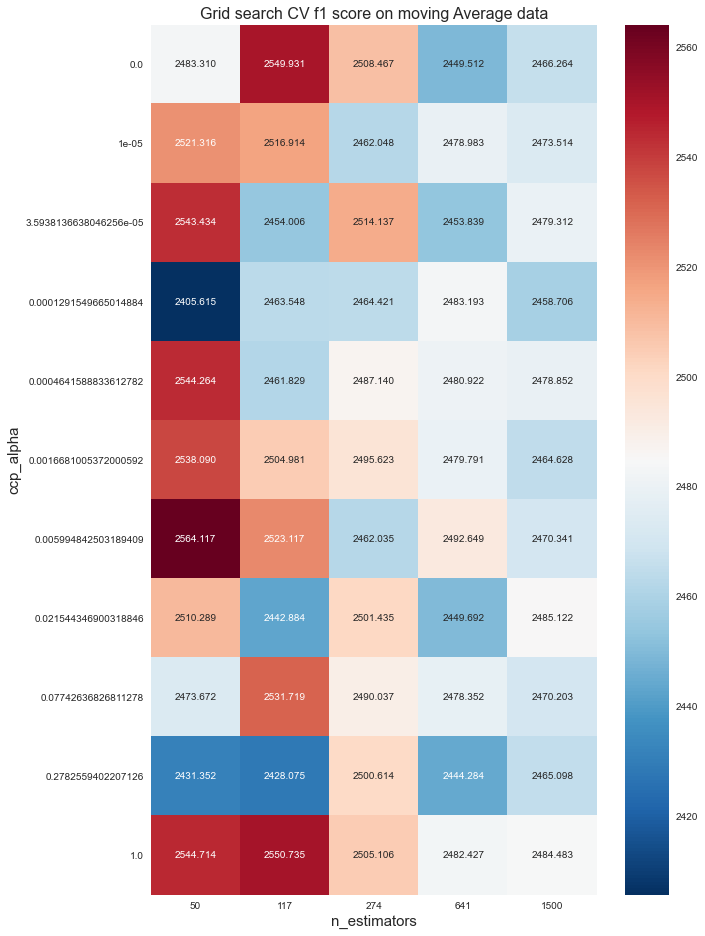

Best hyperparameter: {'ccp_alpha': 0.0001291549665014884, 'n_estimators': 50}
Search time: 394.61783920000016 seconds
mse in validation: mean=2405.6145471343875, std=1263.2414344718106
mae in validation: mean=40.54371343873517, std=12.415260494044615
smape in validation: mean=48.56514523906367, std=36.24610345042335
Depth: mean=13.66, std=1.5047923444781341
Number of nodes: mean=280.28, std=9.597999791623252
Number of leaves: mean=140.64, std=4.798999895811626

VarRUL


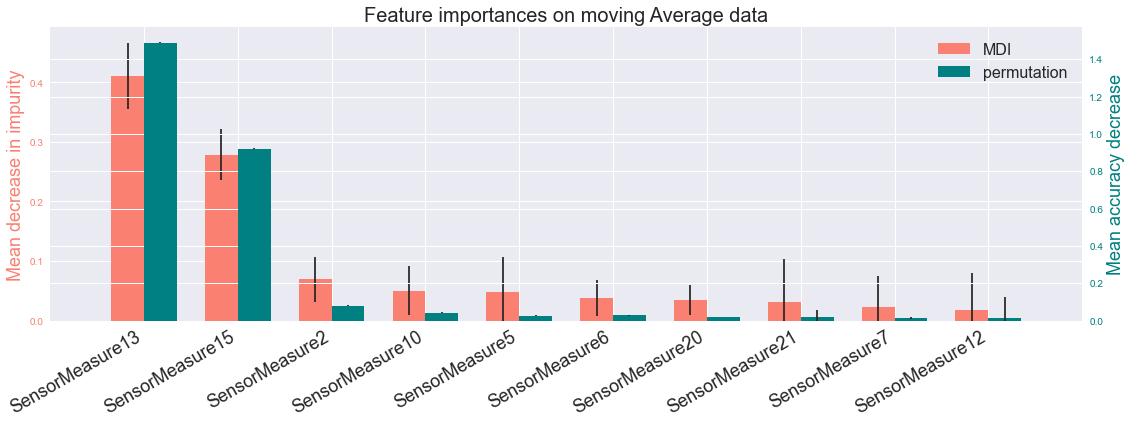

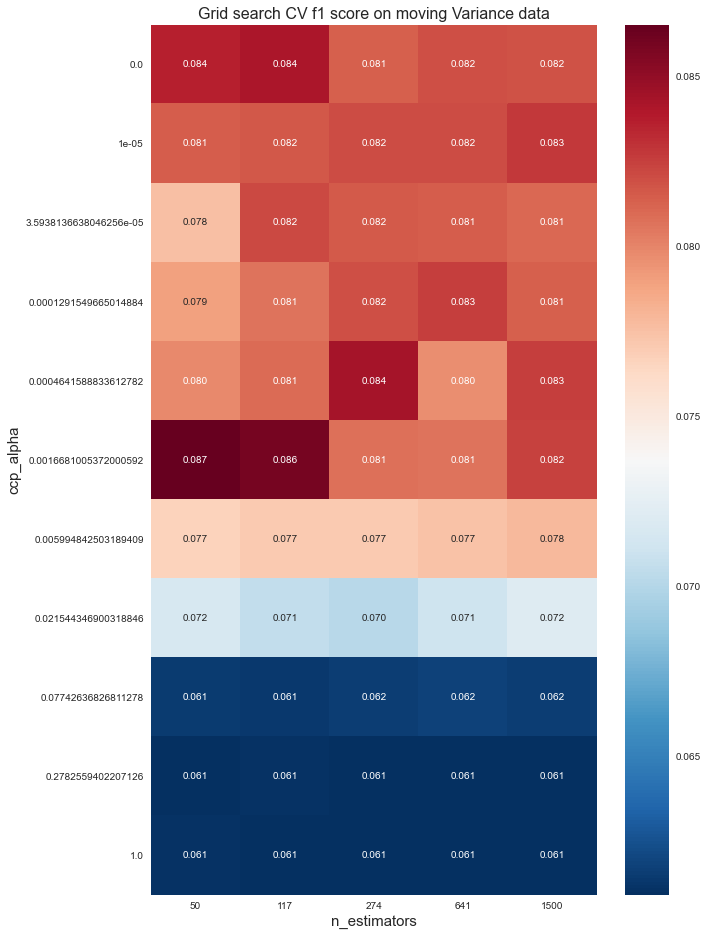

Best hyperparameter: {'ccp_alpha': 0.2782559402207126, 'n_estimators': 50}
Search time: 281.5420376000002 seconds
mse in validation: mean=0.06093267287884021, std=0.17960496727551115
mae in validation: mean=0.060381543042364025, std=0.08342425997536596
smape in validation: mean=3.267131520895024, std=5.866599054987768
Depth: mean=0.0, std=0.0
Number of nodes: mean=1.0, std=0.0
Number of leaves: mean=1.0, std=0.0

MaxRUL


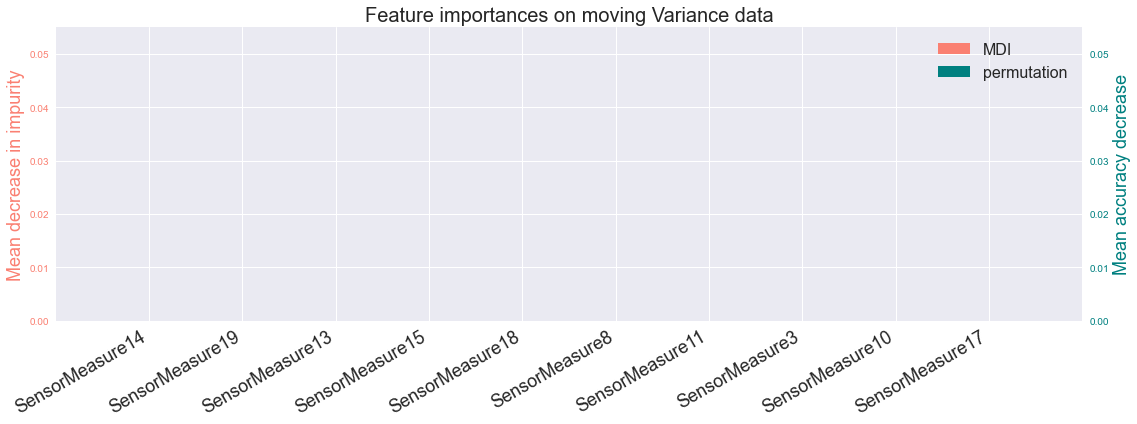

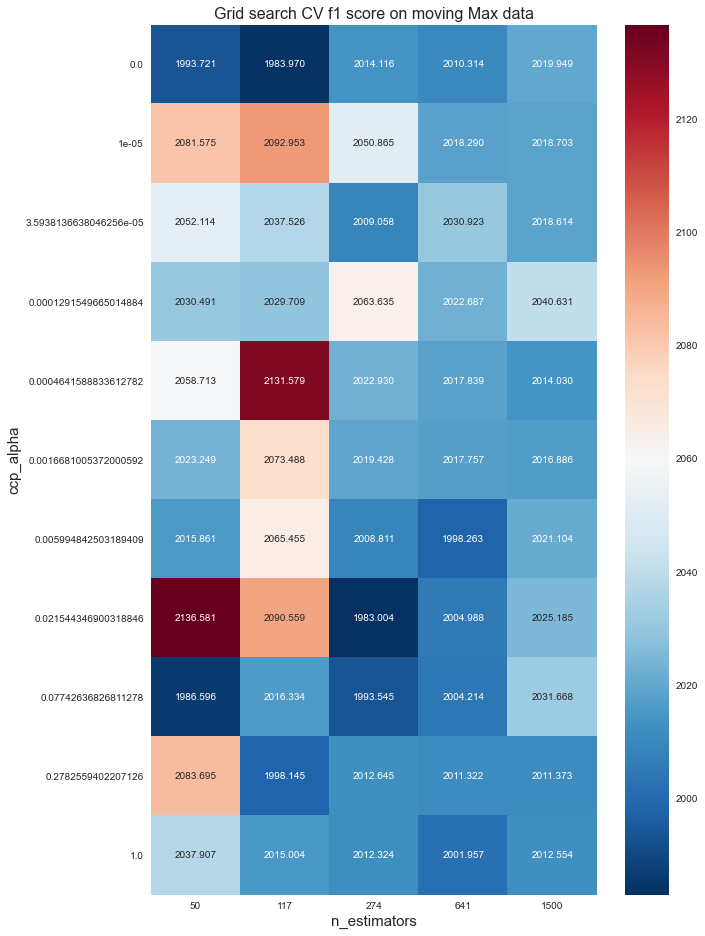

Best hyperparameter: {'ccp_alpha': 0.021544346900318846, 'n_estimators': 274}
Search time: 338.8629487999988 seconds
mse in validation: mean=1983.0042847263583, std=1667.5503337965513
mae in validation: mean=33.744772016669124, std=18.383602687443656
smape in validation: mean=39.07217826794916, std=31.67988047671882
Depth: mean=11.08029197080292, std=1.1208599029550126
Number of nodes: mean=155.62773722627736, std=7.193881523642536
Number of leaves: mean=78.31386861313868, std=3.596940761821268



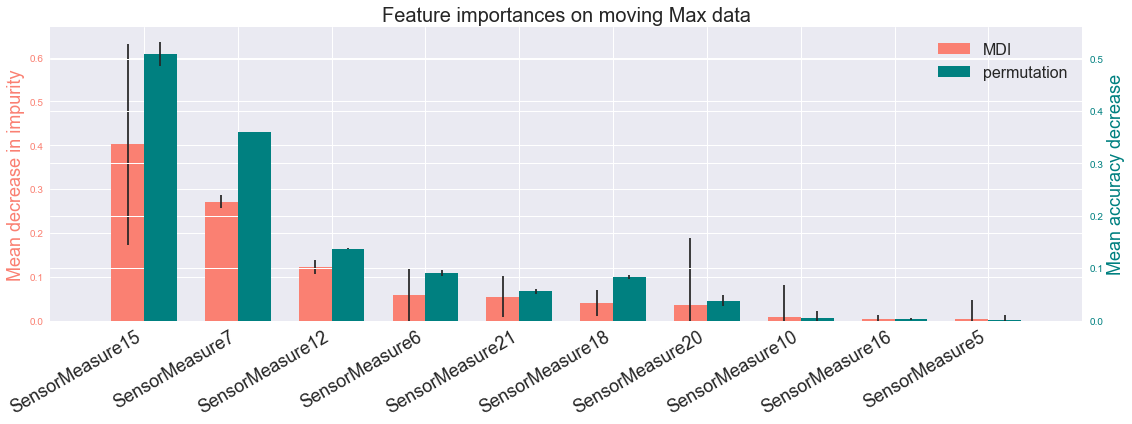

In [145]:
feature_set = [top_sensor_avg, top_sensor_var, top_sensor_max]
feature_df = [m_avg, m_var, m_max]
rul_type = ['AvgRUL', 'VarRUL', 'MaxRUL']
names = ['Average', 'Variance', 'Max']
rul_df = [m_avg_rul, m_var_rul, m_max_rul]
UNIT_NUMBER = 1
SCORING = {'mse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'smape': smape_score} 

for i in range(len(rul_type)):
    print(rul_type[i])
    feature = feature_set[i]
    columns = feature.iloc[
        (feature.index.get_level_values('UnitNumber') == str(UNIT_NUMBER)) & 
        (feature.index.get_level_values('RUL') == rul_type[i])
    ]
    if columns.shape[0] != 1:
        print(f'Multiple top features in iteration {i}!')
        break
    columns = columns.values[0]
    df = pd.merge(feature_df[i], rul_df[i], on=['UnitNumber', 'Cycle'])
    df = df[df.UnitNumber == UNIT_NUMBER]
    X = df[columns]
    y = df[rul_type[i]]
    
    start_time = time.perf_counter()
    parameter = {'n_estimators': np.geomspace(50, 1500, 5).round().astype('int'), 
                 'ccp_alpha': np.concatenate([[0], np.geomspace(1e-5, 1, 10)])}
    rf_gs = GridSearchCV(RandomForestRegressor(), param_grid=parameter, cv=10, scoring=SCORING, 
                         refit='mse', return_train_score=True)
    rf_result = rf_gs.fit(X, y)
    search_time = time.perf_counter() - start_time
    
    report(rf_gs, rf_result, SCORING, X, y, search_time, columns, parameter, names[i])
    print()
    
        
    

## 第三題

#### 基因演算法

將以訂單的執行順序做為一個解，例如，若有5個訂單，則給每個訂單數字編號1、2...5，則12345就是一個解，表示編號一的訂單最先開始執行，完成後執行編號2的訂單。定義完解的表達方式後，則定義
fitness 的計算，計算方法為加權所有訂單 tardiness 的總和，tardiness 為訂單交貨截止日期減掉訂單交貨日期與0 取最大值，其中訂單交貨日期為起始時間、排序在此訂單以前的所有訂單之所需工作時間加總、自己的所需工作時間的總和，如此即可挑出較為好的解。

Reproduction 與原先定義相同，即直接複製的解，接下來定義crossover 以及mutation，crossover無法直接隨機給定個切換點，兩個解在此切換點後交換，此方法可能導致解為非法解，例如一個解中出現兩個一樣的訂單或是缺少某個訂單的工作安排；因此修改為以隨機找兩個切點，則針對切出來的三段工作序列，取其中間段進行交換，則此時可能出現非法的解需要進行修正，給定一個解，將前後兩段中與中間那段出現重複的工作序號的工作替換掉，替換的工作序號為，在中間段重複的工作序號的位置對應到與之crossover 後的解之同一位置，以其位置上的工作序號取代，例如I= 28645713，J= 87213465，則若兩切點於第二到第三位、第五到第六位，則crossover 後為I=28213713，J=87645465，修正過後為I=68213745、J=87645123，（此crossover 修正方法參考CL CHEN,1996）。Mutation 為隨意兩個位置的工作序號交換。GA 為保留其搜尋解的廣與深，所以測試 population size 的設定。

#### Tabu search
- 鄰近解為任意挑選一個 job，任意安插至其他所有可能位置的解。

In [65]:
import time
import numpy as np

class Job:
    def __init__(self, index, processing_time, due_date, weight):
        self.index = index
        self.processing_time = processing_time
        self.due_date = due_date
        self.weight = weight

    def __str__(self):
        return str(self.index)

from functools import total_ordering
@total_ordering
class Solution:

    def __init__(self, solution: list):
        self.solution = np.array(solution)  # FIXME: should be more specific to this type
        self.completion_time = np.cumsum([job.processing_time for job in solution])
        self.tardiness = np.maximum(self.completion_time - [job.due_date for job in solution], 0)
        self.total_tardiness = np.sum(self.tardiness)
        self.total_penalty = self.tardiness @ np.array([job.weight for job in solution])
        # current_time = 0
        # total_tardiness = 0
        # total_penalty = 0
        # for job in self.solution:
        #     current_time += job.processing_time
        #     job.complete_time = current_time
        #     job.tardiness = np.maximum(job.complete_time - job.due_time, 0)
        #     job.penalty = job.tardiness * job.weight
        #     total_tardiness += job.tardiness
        #     total_penalty += job.penalty
        # self.total_tardiness = total_tardiness
        # self.total_penalty = total_penalty

    def __str__(self):
        return ', '.join([str(job) for job in self.solution])

    def __gt__(self, other):
        return self.total_penalty > other.total_penalty
    def __lt__(self, other):
        return self.total_penalty < other.total_penalty
    def __eq__(self, other):
        return self.total_penalty == other.total_penalty
    def __ne__(self, other):
        return self.total_penalty != other.total_penalty

def insertion_complement(fixed_jobs, complement_jobs):
    best_sol = Solution(np.insert(fixed_jobs, len(fixed_jobs), complement_jobs))
    for job in complement_jobs:
        best_sol = Solution(np.insert(fixed_jobs, len(fixed_jobs), job))
        for pos in range(len(fixed_jobs) + 1):
            inserted_sol = Solution(np.insert(fixed_jobs, pos, job))
            if inserted_sol < best_sol:
                best_sol = inserted_sol
        fixed_jobs = best_sol.solution
    return best_sol

class GeneticAlgorithm:

    def __init__(self, population_size, reproduce_rate, mutation_rate, max_iteration, patience):
        self.population_size = population_size
        self.reproduce_rate = reproduce_rate
        self.mutation_rate = mutation_rate
        self.max_iteration = max_iteration
        self.patience = patience

    def generate_initial_solution(self, jobs):
        # sort by due date
        solution_by_due = Solution(sorted(jobs, key=lambda job: job.due_date, reverse=False))
        # sort by processing time
        solution_by_processing_time = Solution(sorted(jobs, key=lambda job: job.processing_time, reverse=False))
        return solution_by_due, solution_by_processing_time

    def crossover_swap(self, sol_1, sol_2):
        # type 1
        parent_1 = sol_1.solution
        parent_2 = sol_2.solution
        cut_1, cut_2 = sorted(np.random.choice(len(parent_1) + 1, 2, replace=False))
        segment_1 = parent_2[cut_1:cut_2]
        segment_2 = parent_1[cut_1:cut_2]
        left_1 = parent_1[:cut_1]
        right_1 = parent_1[cut_2:]
        left_2 = parent_2[:cut_1]
        right_2 = parent_2[cut_2:]
        left_1 = [l.index for l in left_1]
        left_2 = [l.index for l in left_2]
        right_1 = [r.index for r in right_1]
        right_2 = [r.index for r in right_2]
        segment_1 = [s.index for s in segment_1]
        segment_2 = [s.index for s in segment_2]

        # FIXME: TOO duplicated
        for i, val in enumerate(segment_1):
            if val in left_1:
                left_index = left_1.index(val)  # FIXME use index is better
                dual_val = segment_2[i]
                left_1[left_index] = dual_val
                if dual_val in left_2:
                    left_index_2 = left_2.index(dual_val)
                    left_2[left_index_2] = val
                elif dual_val in right_2:
                    right_index_2 = right_2.index(dual_val)
                    right_2[right_index_2] = val
            elif val in right_1:
                right_index = right_1.index(val)
                dual_val = segment_2[i]
                right_1[right_index] = dual_val
                if dual_val in left_2:
                    left_index_2 = left_2.index(dual_val)
                    left_2[left_index_2] = val
                elif dual_val in right_2:
                    right_index_2 = right_2.index(dual_val)
                    right_2[right_index_2] = val
        new_sol_1 = []
        for id in np.concatenate([left_1, segment_1, right_1]):
            for job in sol_1.solution:
                if job.index == id:
                    new_sol_1.append(job)
        new_sol_2 = []
        for id in np.concatenate([left_2, segment_2, right_2]):
            for job in sol_2.solution:
                if job.index == id:
                    new_sol_2.append(job)
        return [
            Solution(new_sol_1),
            Solution(new_sol_2)
        ]

    def crossover_insert(self, sol_1, sol_2):

        parent_1 = sol_1.solution
        parent_2 = sol_2.solution
        pos = np.random.choice(len(parent_1) + 1, 1, replace=False)[0]
        left = parent_1[:pos]
        left_dual = parent_2[np.where(~np.isin(parent_2, left))[0]]
        right_dual = parent_1[pos:]
        right = parent_2[np.where(np.isin(parent_2, left))[0]]


        left_sol = insertion_complement(left, left_dual)
        right_sol = insertion_complement(right, right_dual)
        if np.random.binomial(1, self.mutation_rate):
            right_sol = self.mutation(right_sol)

        return [left_sol, right_sol]


    def mutation(self, sol):
        pos_1, pos_2 = np.random.choice(len(sol.solution), 2, replace=False)
        val_1, val_2 = sol.solution[pos_1], sol.solution[pos_2]
        sol.solution[pos_1] = val_2
        sol.solution[pos_2] = val_1
        return sol

    def search(self, jobs):
        start_time = time.perf_counter()
        bad = 0
        ancestor_1, ancestor_2 = self.generate_initial_solution(jobs)
        generation = [ancestor_1, ancestor_2]
        reproduce_num = int(self.reproduce_rate * self.population_size)
        rest_num = self.population_size - reproduce_num
        for i in range(self.population_size // 2):
            generation = np.concatenate([generation, self.crossover_insert(ancestor_1, ancestor_2)])
        for i in range(self.population_size - self.population_size // 2):
            generation = np.concatenate([generation, self.crossover_swap(ancestor_1, ancestor_2)])
        best_sol = generation[generation.argmin()]
        for iteration in range(self.max_iteration):
            good_parents = np.sort(generation)[:reproduce_num]
            offspring = good_parents
            for i in range(rest_num // 2):  # the crossover rate should be linked to objval:
                pid_1, pid_2 = np.random.choice(len(good_parents) // 3, 2, replace=False)
                offspring = np.concatenate([offspring, self.crossover_insert(good_parents[pid_1], good_parents[pid_2])])
            for j in range(rest_num - rest_num // 2):
                pid_1, pid_2 = np.random.choice(len(good_parents), 2, replace=False)
                offspring = np.concatenate([offspring, self.crossover_insert(good_parents[pid_1], good_parents[pid_2])])
            
#             for j in range(rest_num // 2):
#                 pid_1, pid_2 = np.random.choice(len(good_parents) // 3, 2, replace=False)
#                 offspring = np.concatenate([offspring, self.crossover_swap(good_parents[pid_1], good_parents[pid_2])])
#             for j in range(rest_num - rest_num // 2):
#                 pid_1, pid_2 = np.random.choice(len(good_parents), 2, replace=False)
#                 offspring = np.concatenate([offspring, self.crossover_swap(good_parents[pid_1], good_parents[pid_2])])
            
            if offspring.min() < best_sol:
                best_sol = offspring[offspring.argmin()]
            else:
                bad += 1
                if bad >= self.patience:
                    break
            generation = offspring

        search_time = time.perf_counter() - start_time
        return best_sol, search_time



class TabuSearch:

    def __init__(self, tabu_size):
        self.tabu_size = tabu_size
        self.tabu_list = []
        self.current_sol = None

    def generate_initial_solution(self, jobs):
        # sort by due date
        solution_by_due = Solution(sorted(jobs, key=lambda job: job.due_date, reverse=False))
        return solution_by_due

    def get_neighbor(self, sol):
        jobs = sol.solution
        pos = np.random.choice(len(jobs), len(jobs), replace=False)
        neighborhood = []
        for p in pos:
            neighborhood.append(insertion_complement(np.delete(jobs, p), [jobs[p]]))
        rank_neighbor = np.sort(neighborhood)
        rank_pos = pos[np.argsort(neighborhood)]
        for i in range(len(pos)):
            if rank_pos[i] in self.tabu_list:
                continue
            else:
                best_neighbor = rank_neighbor[i]
                self.tabu_list.append(rank_pos[i])
                self.tabu_list = self.tabu_list[:self.tabu_size]
            # FIXME: may suffer no better sol if tabu size > len(jobs) // 3

        return best_neighbor

    def search(self, jobs, max_iteration, patience):
        start_time = time.perf_counter()
        bad = 0
        next_sol = self.generate_initial_solution(jobs)
        best_sol = next_sol
        for i in range(max_iteration):
            next_sol = self.get_neighbor(next_sol)
            if next_sol < best_sol:
                best_sol = next_sol
            else:
                bad += 1
                if bad >= patience:
                    break
        search_time = time.perf_counter() - start_time
        return best_sol, search_time



In [66]:
indice = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
processing_times = [10, 10, 13, 4, 9, 4, 8, 15, 7, 1, 9, 3, 15, 9, 11, 6, 5, 14, 18, 3]
due_times = [50, 38, 49, 12, 20, 105, 73, 45, 6, 64, 15, 6, 92, 43, 78, 21, 15, 50, 150, 99]
weights = [10, 5, 1, 5, 10, 1, 5, 10, 5, 1, 5, 10, 10, 5, 1, 10, 5, 5, 1, 5]

In [67]:

jobs = []
for index, processing_time, due_time, weight in zip(indice, processing_times, due_times, weights): 
    jobs.append(Job(index, processing_time, due_time, weight)) 
    

In [71]:
for population_size in [30, 60, 120]:
    print(f'Population size: {population_size}')
    ga = GeneticAlgorithm(population_size=population_size, reproduce_rate=0.5, mutation_rate=0.01, max_iteration=50, patience=5)
    best_sol, search = ga.search(jobs)
    print('Solution:', best_sol)
    print('Total weighted tardiness:', best_sol.total_penalty)
    print('Number of tardy jobs:', len(np.nonzero(best_sol.tardiness)[0]))
    print('Search time:', search)
    print()


Population size: 30
Solution: 12, 4, 17, 16, 5, 9, 8, 1, 10, 14, 7, 13, 20, 11, 2, 18, 6, 15, 3, 19
Total weighted tardiness: 1928
Number of tardy jobs: 13
Search time: 1.2191517000001113

Population size: 60
Solution: 12, 4, 17, 16, 5, 9, 8, 1, 10, 14, 7, 13, 20, 11, 2, 18, 6, 15, 3, 19
Total weighted tardiness: 1928
Number of tardy jobs: 13
Search time: 2.463340999999673

Population size: 120
Solution: 12, 4, 17, 16, 5, 9, 8, 1, 10, 14, 7, 13, 20, 11, 2, 18, 6, 15, 3, 19
Total weighted tardiness: 1928
Number of tardy jobs: 13
Search time: 5.135702800000217



In [53]:
for tabu_size in [2, 4, 8, 16,]:
    ts = TabuSearch(tabu_size=2)
    best_sol, search = ts.search(jobs, max_iteration=100, patience=np.inf)
    print('Solution:', best_sol)
    print('Total weighted tardiness:', best_sol.total_penalty)
    print('Number of tardy jobs:', len(np.nonzero(best_sol.tardiness)[0]))
    print('Search time:', search)
    print()

Solution: 9, 12, 4, 11, 17, 5, 16, 2, 14, 8, 3, 1, 18, 10, 7, 15, 13, 20, 6, 19
Total weighted tardiness: 3168
Number of tardy jobs: 20
Search time: 2.090254300000197

Solution: 9, 12, 4, 11, 17, 5, 16, 2, 14, 8, 3, 1, 18, 10, 7, 15, 13, 20, 6, 19
Total weighted tardiness: 3168
Number of tardy jobs: 20
Search time: 2.0654404000001705

Solution: 9, 12, 4, 11, 17, 5, 16, 2, 14, 8, 3, 1, 18, 10, 7, 15, 13, 20, 6, 19
Total weighted tardiness: 3168
Number of tardy jobs: 20
Search time: 2.070589299999938

Solution: 9, 12, 4, 11, 17, 5, 16, 2, 14, 8, 3, 1, 18, 10, 7, 15, 13, 20, 6, 19
Total weighted tardiness: 3168
Number of tardy jobs: 20
Search time: 2.088934099999733



可以發現兩種方法在嘗試的參數中並沒有顯著的改善解的效果，可能是過快收斂至 local optimal，但可以發現 tabu search 因為搜尋的鄰近解相對還是更為受限，因此訓練時間很短，但是效果不佳且解固定；以目前的設定是以 Genetic Algorithm 的效果較佳。 